## This notebook is used to create the initial dataframe (saved as .csv) containing the ground truth information for each (song, artist) pair of the kaggle dataset. Furthermore, the lyrics will be normalized and the dataset balanced such that each mood has approximitally the same amount of songs for better predictions of CNN model.

In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "data"

## Load data

In [3]:
# lyrics data path
lyrics_path = os.path.join(DATA_DIR, "lyrics-data.csv")
df_lyrics = pd.read_csv(lyrics_path)

# artists data path
artists_path = os.path.join(DATA_DIR, "artists-data.csv")
df_artists = pd.read_csv(artists_path)

## Remove non-english songs

In [4]:
# Filter for language en = english
df_lyrics_en = df_lyrics[df_lyrics["language"] == "en"]

## Remove songs with less than 70 and more than 1000 words

In [5]:
# Split each string column and count length
df_lyrics_en = df_lyrics_en[
    df_lyrics_en["Lyric"].apply(lambda lyric: (len(lyric.split()) >= 70) & (len(lyric.split()) <= 1000))
]

## Merge songs and artists

In [6]:
# Merge artists and lyrics
df_songs = pd.merge(
    df_lyrics_en, 
    df_artists, 
    how="inner",
    left_on="ALink",
    right_on="Link"
)

# Remove duplicate columns
del df_songs["Link"]

## Remove columns with duplicate or redundant information

In [7]:
del df_songs["ALink"]
del df_songs["language"]
del df_songs["Songs"]
del df_songs["Popularity"]

## Remove duplicate rows

In [8]:
df_songs_no_duplicates = df_songs.drop_duplicates(subset=['SLink'])

## Add labels from Last.fm

In [9]:
tags_df= pd.read_csv('./data/tags.csv')

In [10]:
df = pd.merge(df_songs_no_duplicates, tags_df,  how='left', left_on=["Artist","SName"], right_on = ["Artist","SName"])

In [11]:
df = df[(df["Tags"] != "NoTagsFound") & (df["Tags"] != "NoSongFound")]

In [12]:
df.head()

,SName,SLink,Lyric,Artist,Genres,Tags
3,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",Ivete Sangalo,Pop; Axé; Romântico,"pop, female vocalists, rnb, hot, spanish, soul..."
5,Human Nature,/ivete-sangalo/human-nature.html,Looking out\nAcross the night time\nThe city w...,Ivete Sangalo,Pop; Axé; Romântico,"pop, rock, female vocalists, dance, latin, rnb..."
9,Natural Collie,/ivete-sangalo/natural-collie.html,Been down in the valley\nSmoking natural colli...,Ivete Sangalo,Pop; Axé; Romântico,"spanish, electronic, female, jazz, hip hop, po..."
10,Where It Begins (feat. Nelly Furtado),/ivete-sangalo/where-it-begins-feat-nelly-furt...,"When you're alone and you don't know how,\nTo ...",Ivete Sangalo,Pop; Axé; Romântico,"pop, singer-songwriter, rnb, Nelly Furtado, sp..."
15,Lazy Groove,/claudia-leitte/lazy-groove.html,Are you ready to dance?\nTo make your body cra...,Claudia Leitte,Pop; Axé; Romântico,"dance, cool, 2013, axe music, claudia leitte"


## Mood ground truth

In [13]:
MOOD_CATEGORIES = {
    'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'],
    'sad': ['sadness', 'unhappy', 'melancholic', 'melancholy'],
    'happy': ['happy', 'happiness', 'happy songs', 'happy music'],
    'romantic': ['romantic', 'romantic music'],
    'upbeat': ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusiastic'],
    'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'],
    'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
    'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
    'dreamy': ['dreamy'],
    'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'],
    'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'],
    'aggression': ['aggression', 'aggressive'],
    'confident': ['confident', 'encouraging', 'encouragement', 'optimism'],
    'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
    'earnest': ['earnest', 'heartfelt'],
    'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'],
    'pessimism': ['pessimism', 'cynical', 'pessimistic', 'weltschmerz'],
    'excitement': ['excitement', 'exciting', 'exhilarating', 'thrill', 'ardor']
}

In [14]:
def get_mood_from_tags(tags):
    """Get mood from tags. If tags does not contain tags mapped to moods then mood is None.

    :param tags: tags of the song.
    :ptype: String
    
    :return: Mood for given tags.
    :rtype: String or None
    """
    
    moods = list(MOOD_CATEGORIES.keys())
    
    # initialize mood_keyword_count_dict
    mood_keyword_count_dict = dict(zip(moods, [0]*len(MOOD_CATEGORIES)))
    
    # create tags list
    if isinstance(tags, str) and tags not in ["NoTagsFound", "NoSongFound"]:
        tags = tags.split(", ")
    else:
        # if no tags available then return None 
        return None

    # compute mood count for all moods based on if tags contains tags mapped to these moods
    for tag in tags:
        for mood in moods:
            if tag in MOOD_CATEGORIES[mood]:
                mood_keyword_count_dict[mood] += 1
                break
            
    # compute the assigned mood (if no mood assigned return None) 
    mood_counts = list(mood_keyword_count_dict.values())
    if max(mood_counts) > 0:
        assigned_mood_idx = np.argmax(mood_counts)
        return list(mood_keyword_count_dict.keys())[assigned_mood_idx]
    else:
        return None

In [15]:
# create mood column to df
df["Mood"] = df["Tags"].apply(get_mood_from_tags)
df = df[df["Mood"].notnull()]

In [16]:
df.head(10)

,SName,SLink,Lyric,Artist,Genres,Tags,Mood
17,Signs,/claudia-leitte/signs.html,I'm lying alone on the floor\nWith a feather I...,Claudia Leitte,Pop; Axé; Romântico,"claudia leitte, Soundtrack, pop, romantic, bra...",romantic
24,I Miss Her,/olodum/i-miss-her.html,Oh lord\nI'd like to know where she is now\nIf...,Olodum,Axé,"brasil, Axe, brazil, carnaval, good for dancin...",happy
38,Halo,/beyonce/halo.html,Remember those walls I built\nWell baby they'r...,Beyoncé,Pop; R&B; Black Music,"pop, rnb, beyonce, female vocalists, soul, Hal...",sad
40,If I Were A Boy,/beyonce/if-i-were-a-boy.html,If I were a Boy\nEven Just for a day\nI'd Roll...,Beyoncé,Pop; R&B; Black Music,"beyonce, rnb, pop, soul, female vocalist, fema...",grief
41,Love On Top,/beyonce/love-on-top.html,"Bring the beat in!\n\nHoney, honey\nI can see ...",Beyoncé,Pop; R&B; Black Music,"soul, rnb, beyonce, pop, female vocalists, gro...",happy
43,Irreplaceable,/beyonce/irreplaceable.html,To the left..\nTo the left..\n\nTo the left to...,Beyoncé,Pop; R&B; Black Music,"rnb, beyonce, pop, female vocalists, soul, irr...",romantic
46,Run The World (Girls),/beyonce/run-the-world-girls.html,"Girls, we run this motha!\nGirls, we run this ...",Beyoncé,Pop; R&B; Black Music,"rnb, dance, beyonce, pop, powerful, female voc...",upbeat
47,Listen,/beyonce/listen.html,"Listen,\nTo the song here in my heart\nA melod...",Beyoncé,Pop; R&B; Black Music,"rnb, soul, Soundtrack, female vocalists, beyon...",grief
53,Single Ladies (Put A Ring On It),/beyonce/single-ladies-put-a-ring-on-it.html,All the single ladies (All the single ladies)\...,Beyoncé,Pop; R&B; Black Music,"beyonce, pop, rnb, dance, female vocalists, Hi...",happy
54,Hello,/beyonce/hello.html,Oh!\nOooooh\nI love to see you walking into th...,Beyoncé,Pop; R&B; Black Music,"beyonce, rnb, pop, female vocalists, soul, Lov...",earnest


In [17]:
print(f"Number of songs with mood: {len(df)}")

Number of songs with mood: 27705


## Clean keywords from Lyrics
Some lyrics contain words like "chorus" instead of the full text, if there is repetition for example. 
In this step we will define those keywords (manually extracted from data) and remove them. 

In [18]:
# lowercase the lyrics
df["Lyric"] = df["Lyric"].str.lower()

### Lyrics keywords exploration
Use these two cells to check for unwanted patterns in text and also to check whether you have filtered this pattern out correctly

In [19]:
# print one example lyrics containing specific keyword (e.g. "chorus"). Might also be helpful to spot further unwanted patterns in the lyrics (like "(4x)")
df[df["Lyric"].str.contains("chorus")]["Lyric"].tolist()[0]

"listen,\nto the song here in my heart\na melody i start\nbut can't complete\n\nlisten, to the sound from deep within\nit's only beginnin'\nto find release\n\noh,\nthe time has come\nfor my dreams to be heard\nthey will not be pushed aside and turned\ninto your own\nall cause you won't\nlisten....\n\n[chorus]\nlisten,\ni am alone in a crossroads\ni'm not at home, in my own home\nand i've tried and tried\nto say whats on my mind\nyou should have known\noh,\nnow i'm done believin' you\nyou don't know what i'm feelin\ni'm more than what, you made of me\ni followed the voice\nyou gave to me\nbut now i've gotta find, my own..\n\nyou should've listened\nthere is someone here inside\nsomeone i'd thought had died\nso long ago\n\nohh i'm screamin' out and my dreams will be heard\nthey will not be pushed aside on words\ninto your own\nall cause you won't\nlisten...\n\n[chorus]\n\ni don't know where i belong\nbut i'll be movin on\nif you don't....\nif you won't....\n\nlisten!!!...\nto the song he

In [20]:
# print text parts of size window_length with parts of lyrics that are containing a certain keyword
keyword = "chorus" # chorus
lyrics_with_keyword = df[df["Lyric"].str.contains(keyword)]["Lyric"].tolist()

# defines how much text around the keyword should be extracted (to obtain all various combinations of that keyword)
window_length = 40
cutted_lyrics_with_keyword = []
for lyric in lyrics_with_keyword:
    # get all occurences positions of that keyword within given lyric
    keyword_positions = [m.start() for m in re.finditer(keyword, lyric)]
    for keyword_position in keyword_positions:
        start_idx = max(0, keyword_position - window_length)
        end_idx = min(len(lyric) - 1, keyword_position + window_length)
        cutted_lyrics_with_keyword.append(lyric[start_idx : end_idx])

# output all parts with given keyword       
for cutted_lyrics_with_keyword_element in cutted_lyrics_with_keyword:
    print(repr(cutted_lyrics_with_keyword_element))

"ur own\nall cause you won't\nlisten....\n\n[chorus]\nlisten,\ni am alone in a crossroa"
"our own\nall cause you won't\nlisten...\n\n[chorus]\n\ni don't know where i belong\nbut"
'[chorus]\nwhen you see that girl comin, ba'
"e, 'please get low.' [please get low]\n\n[chorus]\nwhen you see that girl comin, ba"
"ease get low.'\n[please get low, whoa]\n\n[chorus]\nwhen you see that girl comin, ba"
' hey hey hey\n\nback up back up back up\n\n[chorus]\nwhen you see that girl comin, ba'
'n you mix it up and you all it creole\n\n[chorus - a]\ncreole, when i look real goo'
"e\nmix it all together\nit's a delicacy\n\n[chorus - b]\nso all my red bones get on t"
'n you mix it up and you all it creole\n\n[chorus - a]\ncreole, when i look real goo'
"ou wanna know\nit's your secret creole\n\n[chorus - b]\nso all my red bones get on t"
'e to impress\npull out yo freakum dress\n\nchorus\nooh ooh o\nput cha freakum dress o'
'e to impress\npull out yo freakum dress\n\nchorus\nooh ooh o\nput cha freakum d

### Keyword filtering steps

In [21]:
# filter everything in [..]
df = df.replace("\[[^]]*\]", "", regex=True)
# filter everything in (..)
df =  df.replace("\([^)]*\)", "", regex=True)
# filter everything in {..}
df = df.replace("\{[^}]*\}", "", regex=True)
# filter everything in <..>
df = df.replace("\<[^>]*\>", "", regex=True)
# filter everything in ::..::
df = df.replace("::[^(::)]*::", "", regex=True)

# filter more specific combinations of chorus
df = df.replace("\nchorus\n", "", regex=True)
df = df.replace("\[chorus", "", regex=True)
df = df.replace("\nchorus", "", regex=True)
df = df.replace("pre[-]?chorus", "", regex=True)
df = df.replace("\nrepeat chorus\n", "", regex=True)

In [22]:
df.head(2)

,SName,SLink,Lyric,Artist,Genres,Tags,Mood
17,Signs,/claudia-leitte/signs.html,i'm lying alone on the floor\nwith a feather i...,Claudia Leitte,Pop; Axé; Romântico,"claudia leitte, Soundtrack, pop, romantic, bra...",romantic
24,I Miss Her,/olodum/i-miss-her.html,oh lord\ni'd like to know where she is now\nif...,Olodum,Axé,"brasil, Axe, brazil, carnaval, good for dancin...",happy


## Show the mood distribution to finetune the moods

In [23]:
df["Mood"].unique()

array(['romantic', 'happy', 'sad', 'grief', 'upbeat', 'earnest',
       'cheerful', 'depressed', 'anger', 'calm', 'excitement',
       'aggression', 'confident', 'angst', 'brooding', 'desire',
       'pessimism'], dtype=object)

In [24]:
moods = { 'romantic': 0, 'happy': 0, 'sad': 0, 'grief': 0, 'upbeat': 0, 'earnest': 0,
       'cheerful': 0, 'depressed': 0, 'anger': 0, 'calm': 0, 'excitement': 0,
       'aggression': 0, 'confident': 0, 'angst': 0, 'brooding': 0, 'desire': 0,
       'pessimism': 0 }
for row in range(len(df)):
    mood = df.iloc[row]["Mood"]
    moods[mood] += 1

In [25]:
print(moods)

{'romantic': 2293, 'happy': 5094, 'sad': 8104, 'grief': 434, 'upbeat': 2398, 'earnest': 144, 'cheerful': 270, 'depressed': 2613, 'anger': 1477, 'calm': 3637, 'excitement': 166, 'aggression': 567, 'confident': 69, 'angst': 213, 'brooding': 100, 'desire': 123, 'pessimism': 3}


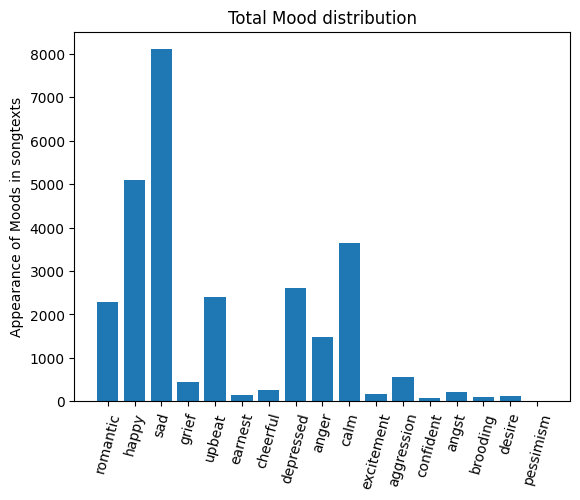

In [26]:
labels = [ k for k,v in moods.items()]
data = [ v for k,v in moods.items()]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

### combine moods with low quantities if possible, else discard them
The combination is the same as in  our baseline project. This includes that we will only use 4 quadrants as moods (happy, sad, calm anger) by combining all the lower level moods appropriately, based on the keywords used to label them. We also incuded more moods than the baseline project, which discarded the following: dreamy, desire, earnest, pessimism, romantic, brooding, whereas we discarded desire, romantic, confident, dreamy (as it was not present in the dataset)

Hence the following applies:

happy = cheerfull, happy, excitement, upbeat

sad = grief, sad, pessimism, angst, depressed

calm = calm, brooding, earnest

anger = anger, aggression


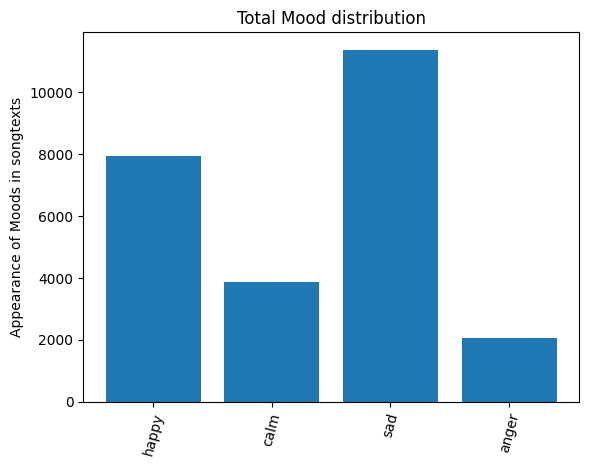

In [27]:
new_moods = {
    "happy": moods["happy"] + moods["cheerful"] + moods["excitement"] + moods["upbeat"],
    "calm": moods["calm"]+moods["brooding"] + moods["earnest"],
    "sad": moods["sad"] + moods["grief"] + moods["pessimism"] + moods["angst"] + moods["depressed"],
    "anger": moods["anger"] + moods["aggression"]
} 

labels = [ k for k,v in new_moods.items()]
data = [ v for k,v in new_moods.items()]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

### Alternative combination

We propose another way of combining the moods whilest maintaining as much as possible moods to have the user labeled his song with a less generalistic mood than just happy like this:

enthusiastic = excitement, upbeat, cheerfull

happy = happy

sad = grief, sad 

depressed = pessimism, angst, depressed

romantic = romantic, desire

calm = calm, brooding, earnest

anger = anger, aggression

This approach manages to incorporate all prior moods (without dreamy) whilest enabling 7 moods for classification instead of 1

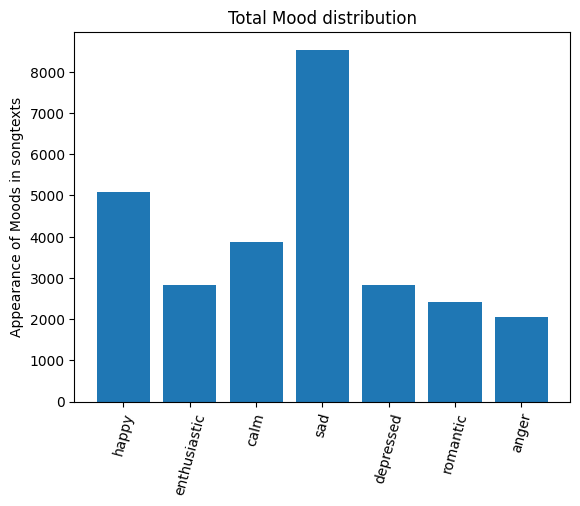

In [28]:
alt_new_moods = {
    "happy": moods["happy"],
    "enthusiastic": moods["cheerful"] + moods["excitement"] + moods["upbeat"],
    "calm": moods["calm"]+moods["brooding"] + moods["earnest"],
    "sad": moods["sad"] + moods["grief"],
    "depressed": moods["pessimism"] + moods["angst"] + moods["depressed"],
    "romantic": moods["romantic"] + moods["desire"],
    "anger": moods["anger"] + moods["aggression"]
} 

labels = [ k for k,v in alt_new_moods.items()]
data = [ v for k,v in alt_new_moods.items()]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

both approaches will be tested with the CNN

### normalize/cap ammount of songs for a given mood, so that it does not dominate the dataset

In [29]:
def normalize_df(limit, df):
    moods = df["Mood"].unique()
    helper = pd.DataFrame(columns=["SName", "SLink", "Lyric", "Artist", "Genres", "Tags", "Mood"])
    for mood in moods:
        df_for_mood = df[df["Mood"] == mood]
        if len(df_for_mood)> limit:
            df_for_mood = df_for_mood.iloc[0:limit]
        helper = pd.concat([helper, df_for_mood])
    return helper

In [30]:
quadrants_df = df.copy()
quadrants_df["Mood"] = quadrants_df["Mood"].replace(["cheerful", "excitement", "upbeat"], "happy")
quadrants_df["Mood"] = quadrants_df["Mood"].replace(["brooding", "earnest"], "calm")
quadrants_df["Mood"] = quadrants_df["Mood"].replace(["grief", "pessimism", "angst", "depressed"], "sad")
quadrants_df["Mood"] = quadrants_df["Mood"].replace(["aggression"], "anger")
# drop rows with moods not included (desire, romantic, confident, dreamy)
quadrants_df = quadrants_df[(quadrants_df["Mood"] != "romantic") & (quadrants_df["Mood"] != "desire") & (quadrants_df["Mood"] != "confident") & (quadrants_df["Mood"] != "dreamy") ]
# limit every mood to only have about the average ammount of songs
limit = int(np.min([v for k,v in new_moods.items()]))
quadrants_df = normalize_df(limit, quadrants_df)


## alternative approach
alt_moods_df = df.copy()
alt_moods_df["Mood"] = alt_moods_df["Mood"].replace(["desire"], "romantic")
alt_moods_df["Mood"] = alt_moods_df["Mood"].replace(["confident","cheerful", "excitement", "upbeat"], "enthusiastic")
alt_moods_df["Mood"] = alt_moods_df["Mood"].replace(["brooding","earnest"],"calm")
alt_moods_df["Mood"] = alt_moods_df["Mood"].replace(["grief"], "sad")
alt_moods_df["Mood"] = alt_moods_df["Mood"].replace(["pessimism","angst"], "depressed")
alt_moods_df["Mood"] = alt_moods_df["Mood"].replace(["aggression"], "anger")
# drop rows with moods not included (dreamy)
alt_moods_df = alt_moods_df[alt_moods_df["Mood"] != "dreamy"]
# limit every mood to only have about the average ammount of songs
limit = int(np.min([v for k,v in alt_new_moods.items()]))
alt_moods_df = normalize_df(limit, alt_moods_df)

## This notebook was for the first cut solution of a CNN + for evaluating the different dataset we generated from our data in accordance with the CNN predictions

### Print new distributions

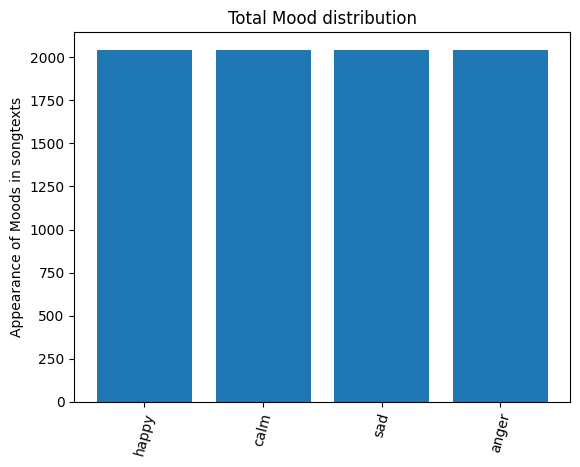

In [31]:
new_moods = {
    "happy": len(quadrants_df[quadrants_df["Mood"] == "happy"]),
    "calm": len(quadrants_df[quadrants_df["Mood"] == "calm"]),
    "sad": len(quadrants_df[quadrants_df["Mood"] == "sad"]),
    "anger": len(quadrants_df[quadrants_df["Mood"] == "anger"])
} 

labels = [ k for k,v in new_moods.items()]
data = [ v for k,v in new_moods.items()]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

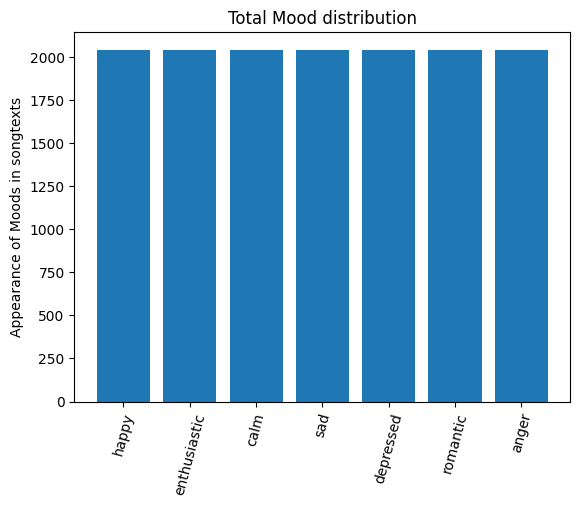

In [32]:
alt_new_moods = {
    "happy": len(alt_moods_df[alt_moods_df["Mood"] == "happy"]),
    "enthusiastic": len(alt_moods_df[alt_moods_df["Mood"] == "enthusiastic"]),
    "calm": len(alt_moods_df[alt_moods_df["Mood"] == "calm"]),
    "sad": len(alt_moods_df[alt_moods_df["Mood"] == "sad"]),
    "depressed":len(alt_moods_df[alt_moods_df["Mood"] == "depressed"]),
    "romantic": len(alt_moods_df[alt_moods_df["Mood"] == "romantic"]),
    "anger": len(alt_moods_df[alt_moods_df["Mood"] == "anger"])
} 

labels = [ k for k,v in alt_new_moods.items()]
data = [ v for k,v in alt_new_moods.items()]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

## Save data

In [33]:
song_data_labels_cleaned_path = os.path.join(DATA_DIR, "song-data-labels-cleaned.csv")
df.to_csv(song_data_labels_cleaned_path, index=False)

song_data_labels_cleaned_path_quadrant = os.path.join(DATA_DIR, "song-data-labels-cleaned-quadrant.csv")
quadrants_df.to_csv(song_data_labels_cleaned_path_quadrant, index=False)

song_data_labels_cleaned_path_seven_moods = os.path.join(DATA_DIR, "song-data-labels-cleaned-seven-moods.csv")
alt_moods_df.to_csv(song_data_labels_cleaned_path_seven_moods, index=False)